# Term Project: Implementing ML Models from Scratch
## Machine Learning / Pattern Recognition
### FINAL INTERNATIONAL UNIVERSITY | Fall 2025-26

**Student Name:HAKIZIMANA TONY CARLIN**  
**Student ID:2510140033**  
**Due Date:** 27 December 2025 (Saturday) before midnight

---

## Overview

In this project, you will implement three fundamental machine learning models **from scratch**:
1. **Linear Regression** using gradient descent
2. **Logistic Regression** using gradient descent (binary classification)
3. **Decision Tree** using information gain (multi-class classification)

You will use the **Iris dataset** for all three tasks:
- **Linear Regression**: Predict `petal_width` from other features
- **Logistic Regression**: Classify `setosa` vs `non-setosa` (binary)
- **Decision Tree**: Classify all three species (multi-class)

**Important Rules:**
- ✅ **Allowed**: `sklearn` for dataset loading, `KFold`, and evaluation metrics
- ❌ **Not Allowed**: `sklearn` models (e.g., `LinearRegression`, `LogisticRegression`, `DecisionTreeClassifier`)
- ❌ **Not Allowed**: `GridSearchCV` or similar libraries for hyperparameter search
- All models must be implemented using **native Python and NumPy only**

**Grading:**
- Linear Regression Implementation: **20 pts**
- Linear Regression 5-Fold CV & Results: **10 pts**
- Logistic Regression Implementation: **20 pts**
- Logistic Regression 5-Fold CV & Results: **10 pts**
- Decision Tree Implementation: **20 pts**
- Decision Tree 5-Fold CV & Results: **10 pts**
- Written Questions (3 × 4 pts): **12 pts** 
- **Total: 100 + 2 pts**

**Integrity Test:**
- **Date**: 3 January 2026 during lecture hours
- **Format**: Short quiz on paper
- **Pass (≥80%)**: Marks awarded directly from PDF
- **Fail (<80%)**: Demo session required
- **No Show**: 50% penalty

---

## Pre-Submission Checklist

- [ ] Name and student ID at top
- [ ] No cells are added or removed
- [ ] All TODO sections completed
- [ ] All questions answered
- [ ] Code runs without errors
- [ ] Results tables included with mean, std, and 95% CI
- [ ] Hyperparameter tuning plots included
- [ ] Run All before saving

## Setup and Imports

In [9]:
# Standard libraries
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Sklearn - ONLY for dataset, splitting, and metrics
from sklearn.datasets import load_iris
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
seed = 42
np.random.seed(seed)

## Load and Prepare Dataset

In [10]:
# Load Iris dataset
iris = load_iris()
X_full = iris.data  # Features: sepal_length, sepal_width, petal_length, petal_width
y_full = iris.target  # Labels: 0=setosa, 1=versicolor, 2=virginica

print("Dataset Information:")
print(f"  Total samples: {X_full.shape[0]}")
print(f"  Features: {iris.feature_names}")
print(f"  Classes: {iris.target_names}")
print(f"\nClass distribution: {dict(zip(iris.target_names, np.bincount(y_full)))}")

Dataset Information:
  Total samples: 150
  Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
  Classes: ['setosa' 'versicolor' 'virginica']

Class distribution: {np.str_('setosa'): np.int64(50), np.str_('versicolor'): np.int64(50), np.str_('virginica'): np.int64(50)}


## Helper Functions

In [11]:
def compute_confidence_interval(values, confidence=0.95):
    """
    Compute mean, std, and 95% confidence interval.
    
    Args:
        values: List or array of values from k folds
        confidence: Confidence level (default 0.95)
    
    Returns:
        mean, std, (lower_bound, upper_bound)
    """
    values = np.array(values)
    n = len(values)
    mean = np.mean(values)
    std = np.std(values, ddof=1)  # Sample std
    
    # t-value for 95% CI with n-1 degrees of freedom (approx 2.776 for n=5)
    t_value = 2.776  # For 5 folds, df=4
    margin = t_value * (std / np.sqrt(n))
    
    return mean, std, (mean - margin, mean + margin)


def print_results(metric_name, values):
    """Print results with mean, std, and 95% CI."""
    mean, std, ci = compute_confidence_interval(values)
    print(f"{metric_name}: {mean:.4f} ± {std:.4f} (95% CI: [{ci[0]:.4f}, {ci[1]:.4f}])")

---

# Task 1: Linear Regression (30 points)

Implement Linear Regression using gradient descent to predict `petal_width` from the other three features (`sepal_length`, `sepal_width`, `petal_length`).

**Hyperparameters to tune:**
- Learning rate: `[0.001, 0.01, 0.1]`
- Regularisation strength (L2): `[0.01, 0.1]`

## 1.1: Implement LinearRegression Class (20 points)

In [12]:
class LinearRegression:
    """
    Linear Regression using gradient descent.
    
    Attributes:
        learning_rate: Step size for gradient descent
        n_iterations: Number of training iterations (fixed = 500)
        reg_strength: L2 regularisation strength (0 = no regularisation)
        weights: Model weights (including bias)
        train_losses: List of training losses per iteration
        val_losses: List of validation losses per iteration
    """
    
    def __init__(self, n_iterations=500, learning_rate=0.01, reg_strength=0.0):
        """
        Initialise the Linear Regression model.
        
        Args:
            learning_rate: Step size for gradient descent
            n_iterations: Number of training iterations
            reg_strength: L2 regularisation strength
        """
        # TODO: Store hyperparameters and initialise attributes (3 points)
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.reg_strength = reg_strength
        self.weights = None
        self.train_losses = []
        self.val_losses = []
    
    def _add_bias(self, X):
        """Add a column of ones for the bias term."""
        # TODO: Add bias column to X (2 points)
        # Hint: Use np.c_ or np.column_stack
        return np.c_[np.ones(X.shape[0]), X]
    
    def _compute_loss(self, X, y):
        """
        Compute Mean Squared Error loss with optional L2 regularisation.
        
        Loss = (1/2n) * sum((y_pred - y)^2) + (reg_strength/2) * sum(weights^2)
        
        Note: Do not regularise the bias term.
        """
        # TODO: Implement MSE loss with L2 regularisation (2 points)
        y_pred = X @ self.weights
        mse_loss = (1 / (2 * len(y))) * np.sum((y_pred - y) ** 2)
        reg_loss = (self.reg_strength / 2) * np.sum(self.weights[1:] ** 2)  # Exclude bias
        return mse_loss + reg_loss
    
    def _compute_gradient(self, X, y):
        """
        Compute gradient of the loss function.
        
        Gradient = (1/n) * X.T @ (X @ weights - y) + reg_strength * weights
        
        Note: Do not regularise the bias term.
        """
        # TODO: Implement gradient computation (2 points)
        y_pred = X @ self.weights
        gradient = (1 / len(y)) * X.T @ (y_pred - y)
        gradient[1:] += self.reg_strength * self.weights[1:]  # Don't regularize bias
        return gradient
    
    def fit(self, X_train, y_train, X_val=None, y_val=None):
        """
        Train the model using gradient descent.
        
        Args:
            X_train: Training features
            y_train: Training targets
            X_val: Validation features (optional, for tracking val loss)
            y_val: Validation targets (optional)
        
        Returns:
            self
        """
        # TODO: Implement training loop (8 points)
        # Steps:
        # 1. Add bias to X_train (and X_val if provided)
        # 2. Initialise weights to zeros
        # 3. For each iteration:
        #    a. Compute gradient
        #    b. Update weights
        #    c. Record train loss
        #    d. Record val loss if X_val provided
        X_train_bias = self._add_bias(X_train)
        if X_val is not None:
            X_val_bias = self._add_bias(X_val)
        
        n_features = X_train_bias.shape[1]
        self.weights = np.zeros(n_features)
        
        self.train_losses = []
        self.val_losses = []
        
        for _ in range(self.n_iterations):
            gradient = self._compute_gradient(X_train_bias, y_train)
            self.weights -= self.learning_rate * gradient
            
            train_loss = self._compute_loss(X_train_bias, y_train)
            self.train_losses.append(train_loss)
            
            if X_val is not None:
                val_loss = self._compute_loss(X_val_bias, y_val)
                self.val_losses.append(val_loss)
        
        return self
    
    def predict(self, X):
        """
        Make predictions.
        
        Args:
            X: Features
        
        Returns:
            Predictions
        """
        # TODO: Add bias and compute predictions (3 points)
        X_bias = self._add_bias(X)
        return X_bias @ self.weights

## 1.2: 5-Fold Cross-Validation for Linear Regression (10 points)

**Steps:**
1. Prepare data: Use features [0, 1, 2] to predict feature [3] (petal_width)
2. For each fold:
   - Split train into train_inner and validation (80%-20%)
   - Grid search over hyperparameters using validation set
   - Train final model with best hyperparameters on full train set
   - Evaluate on test set
3. Report results with mean, std, and 95% CI
4. Plot train/val loss curves for one fold

In [13]:
# Prepare data for Linear Regression
# Features: sepal_length, sepal_width, petal_length
# Target: petal_width
X_linreg = X_full[:, :3]  # First 3 features
y_linreg = X_full[:, 3]   # 4th feature as target

# Standardise features
scaler = StandardScaler()
X_linreg = scaler.fit_transform(X_linreg)

print(f"Linear Regression Data:")
print(f"  X shape: {X_linreg.shape}")
print(f"  y shape: {y_linreg.shape}")

# Hyperparameter grid
learning_rates = [0.001, 0.01, 0.1]
reg_strengths = [0.01, 0.1]

# Storage for results
mse_scores = []
r2_scores = []
best_params_per_fold = []

# For plotting (save from one fold)
plot_train_losses = None
plot_val_losses = None
plot_fold = 1

# 5-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=seed)

print("\n" + "="*60)
print("LINEAR REGRESSION: 5-FOLD CROSS-VALIDATION")
print("="*60)

for fold_num, (train_idx, test_idx) in enumerate(kf.split(X_linreg), 1):
    print(f"\n--- Fold {fold_num} ---")
    
    # Split data
    X_train_full, X_test = X_linreg[train_idx], X_linreg[test_idx]
    y_train_full, y_test = y_linreg[train_idx], y_linreg[test_idx]
    
    # TODO: Further split train into train_inner and validation (80%-20%) (1 points)
    # Hint: Use simple index slicing or another KFold split
    split_idx = max(1, int(0.8 * len(X_train_full)))  # Ensure at least 1 sample for training
    X_train_inner, X_val = X_train_full[:split_idx], X_train_full[split_idx:]
    y_train_inner, y_val = y_train_full[:split_idx], y_train_full[split_idx:]
    
    # Ensure validation set is not empty
    if len(X_val) == 0:
        # If validation set is empty, use last sample from training as validation
        split_idx = len(X_train_full) - 1
        X_train_inner, X_val = X_train_full[:split_idx], X_train_full[split_idx:]
        y_train_inner, y_val = y_train_full[:split_idx], y_train_full[split_idx:]
    
    # TODO: Grid search over hyperparameters (3 points)
    # For each combination of (learning_rate, reg_strength):
    #   1. Train model on train_inner
    #   2. Evaluate on validation set
    #   3. Track best parameters based on validation MSE
    best_val_mse = float('inf')
    best_params = None
    
    for lr in learning_rates:
        for reg in reg_strengths:
            model = LinearRegression(learning_rate=lr, reg_strength=reg)
            model.fit(X_train_inner, y_train_inner, X_val, y_val)
            val_mse = mean_squared_error(y_val, model.predict(X_val))
            if val_mse < best_val_mse:
                best_val_mse = val_mse
                best_params = (lr, reg)
                if fold_num == plot_fold and lr == 0.01 and reg == 0.1:  # Middle values
                    plot_train_losses = model.train_losses
                    plot_val_losses = model.val_losses
    
    best_params_per_fold.append(best_params)
    # TODO: Train final model with best parameters on full training set (1 points)
    final_model = LinearRegression(learning_rate=best_params[0], reg_strength=best_params[1])
    final_model.fit(X_train_full, y_train_full)
    
    # TODO: Evaluate on test set and store results (1 points)
    y_pred = final_model.predict(X_test)
    mse_scores.append(mean_squared_error(y_test, y_pred))
    r2_scores.append(r2_score(y_test, y_pred))
    
    print(f"Best params: lr={best_params[0]}, reg={best_params[1]}")
    print(f"Test MSE: {mse_scores[-1]:.4f}, R²: {r2_scores[-1]:.4f}")

# TODO: Print final results with mean, std, and 95% CI (1 points)
print("\n" + "="*60)
print("LINEAR REGRESSION: FINAL RESULTS")
print("="*60)

print_results("MSE", mse_scores)
print_results("R² Score", r2_scores)

Linear Regression Data:
  X shape: (150, 3)
  y shape: (150,)

LINEAR REGRESSION: 5-FOLD CROSS-VALIDATION

--- Fold 1 ---
Best params: lr=0.1, reg=0.01
Test MSE: 0.0449, R²: 0.9293

--- Fold 2 ---
Best params: lr=0.1, reg=0.01
Test MSE: 0.0248, R²: 0.9535

--- Fold 3 ---
Best params: lr=0.1, reg=0.01
Test MSE: 0.0357, R²: 0.9368

--- Fold 4 ---
Best params: lr=0.1, reg=0.01
Test MSE: 0.0458, R²: 0.9228

--- Fold 5 ---
Best params: lr=0.1, reg=0.01
Test MSE: 0.0418, R²: 0.9121

LINEAR REGRESSION: FINAL RESULTS
MSE: 0.0386 ± 0.0087 (95% CI: [0.0279, 0.0494])
R² Score: 0.9309 ± 0.0155 (95% CI: [0.9116, 0.9502])


C:\Users\viper23\AppData\Local\Temp\ipykernel_14212\813153716.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


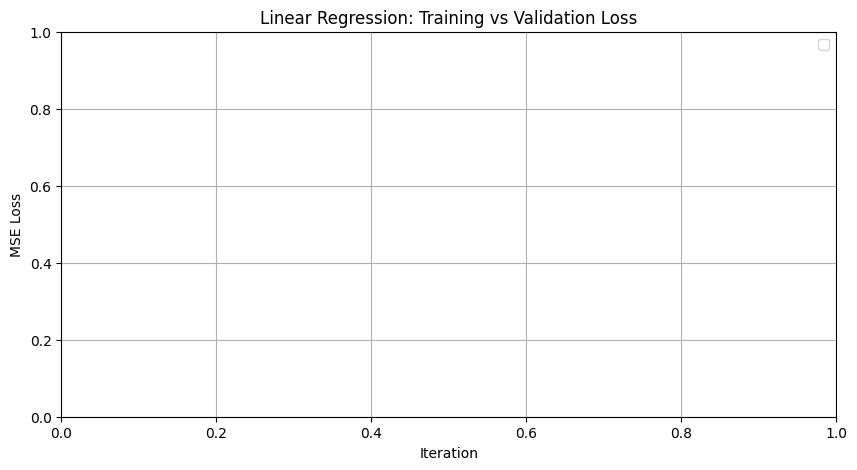

In [14]:
# TODO: Plot training and validation loss curves (1 points)
# Use plot_train_losses and plot_val_losses saved from fold 1

plt.figure(figsize=(10, 5))
# TODO: Create the plot (1 points)
if plot_train_losses is not None and plot_val_losses is not None:
    plt.plot(plot_train_losses, label='Training Loss')
    plt.plot(plot_val_losses, label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('MSE Loss')
plt.title('Linear Regression: Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

**Question 1:** Explain how L2 regularisation affects the weights during training. (4 points, 4-5 sentences)

**L2 regularization adds a penalty term to the loss function that is proportional to the square of the magnitude of the weights. This penalty encourages the model to use smaller weights, preventing overfitting by discouraging complex models. During training, the regularization term affects the gradient computation by adding a component that pushes weights toward zero, with larger weights being penalized more heavily. This leads to smoother weight updates and helps prevent the model from fitting noise in the training data. Additionally, L2 regularization improves the model's generalization performance by reducing variance while maintaining reasonable bias.**

---

# Task 2: Logistic Regression (30 points)

Implement Logistic Regression using gradient descent for binary classification. You will classify `setosa` (class 0) vs `non-setosa` (classes 1 and 2).

**Hyperparameters to tune:**
- Learning rate: `[0.001, 0.01, 0.1]`
- Regularisation strength (L2): `[0.01, 0.1]`

## 2.1: Implement LogisticRegression Class (20 points)

In [15]:
class LogisticRegression:
    """
    Logistic Regression using gradient descent for binary classification.
    
    Attributes:
        learning_rate: Step size for gradient descent
        n_iterations: Number of training iterations (fixed 500)
        reg_strength: L2 regularisation strength
        weights: Model weights (including bias)
        train_losses: List of training losses per iteration
        val_losses: List of validation losses per iteration
    """
    
    def __init__(self, learning_rate=0.01, n_iterations=500, reg_strength=0.0):
        """
        Initialise the Logistic Regression model.
        
        Args:
            learning_rate: Step size for gradient descent
            n_iterations: Number of training iterations
            reg_strength: L2 regularisation strength
        """
        # TODO: Store hyperparameters and initialise attributes
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.reg_strength = reg_strength
        self.weights = None
        self.train_losses = []
        self.val_losses = []
    
    def _add_bias(self, X):
        """Add a column of ones for the bias term."""
        # TODO: Add bias column to X (2 points)
        return np.c_[np.ones(X.shape[0]), X]
    
    def _sigmoid(self, z):
        """
        Compute sigmoid function.
        
        sigmoid(z) = 1 / (1 + exp(-z))
        
        Hint: Clip z to avoid overflow (e.g., np.clip(z, -500, 500))
        """
        # TODO: Implement sigmoid (2 points)
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))
    
    def _compute_loss(self, X, y):
        """
        Compute binary cross-entropy loss with optional L2 regularisation.
        
        Loss = -(1/n) * sum(y*log(p) + (1-y)*log(1-p)) + (reg_strength/2) * sum(weights^2)
        
        Hint: Use np.clip on probabilities to avoid log(0)
        Note: Do not regularise the bias term.
        """
        # TODO: Implement cross-entropy loss with L2 regularisation (2 points)
        probabilities = self._sigmoid(X @ self.weights)
        probabilities = np.clip(probabilities, 1e-15, 1 - 1e-15)  # Avoid log(0)
        cross_entropy = -np.mean(y * np.log(probabilities) + (1 - y) * np.log(1 - probabilities))
        reg_loss = (self.reg_strength / 2) * np.sum(self.weights[1:] ** 2)  # Exclude bias
        return cross_entropy + reg_loss
    
    def _compute_gradient(self, X, y):
        """
        Compute gradient of the loss function.
        
        Gradient = (1/n) * X.T @ (sigmoid(X @ weights) - y) + reg_strength * weights
        
        Note: Do not regularise the bias term.
        """
        # TODO: Implement gradient computation (2 points)
        probabilities = self._sigmoid(X @ self.weights)
        gradient = (1 / len(y)) * X.T @ (probabilities - y)
        gradient[1:] += self.reg_strength * self.weights[1:]  # Don't regularize bias
        return gradient
    
    def fit(self, X_train, y_train, X_val=None, y_val=None):
        """
        Train the model using gradient descent.
        
        Args:
            X_train: Training features
            y_train: Training labels (0 or 1)
            X_val: Validation features (optional)
            y_val: Validation labels (optional)
        
        Returns:
            self
        """
        # TODO: Implement training loop (8 points)
        # Steps:
        # 1. Add bias to X_train (and X_val if provided)
        # 2. Initialise weights to zeros
        # 3. For each iteration:
        #    a. Compute gradient
        #    b. Update weights
        #    c. Record train loss
        #    d. Record val loss if X_val provided
        X_train_bias = self._add_bias(X_train)
        if X_val is not None:
            X_val_bias = self._add_bias(X_val)
        
        n_features = X_train_bias.shape[1]
        self.weights = np.zeros(n_features)
        
        self.train_losses = []
        self.val_losses = []
        
        for _ in range(self.n_iterations):
            gradient = self._compute_gradient(X_train_bias, y_train)
            self.weights -= self.learning_rate * gradient
            
            train_loss = self._compute_loss(X_train_bias, y_train)
            self.train_losses.append(train_loss)
            
            if X_val is not None:
                val_loss = self._compute_loss(X_val_bias, y_val)
                self.val_losses.append(val_loss)
        
        return self
    
    def predict_proba(self, X):
        """
        Predict probabilities.
        
        Args:
            X: Features
        
        Returns:
            Probabilities of class 1
        """
        # TODO: Add bias and compute probabilities using sigmoid (2 points)
        X_bias = self._add_bias(X)
        return self._sigmoid(X_bias @ self.weights)
    
    def predict(self, X, threshold=0.5):
        """
        Make class predictions.
        
        Args:
            X: Features
            threshold: Classification threshold (default 0.5)
        
        Returns:
            Class predictions (0 or 1)
        """
        # TODO: Get probabilities and apply threshold (2 points)
        probabilities = self.predict_proba(X)
        return (probabilities >= threshold).astype(int)

## 2.2: 5-Fold Cross-Validation for Logistic Regression (10 points)

**Steps:**
1. Prepare data: Binary labels (setosa=1, non-setosa=0)
2. For each fold:
   - Split train into train_inner and validation (80%-20%)
   - Grid search over hyperparameters using validation set
   - Train final model with best hyperparameters on full train set
   - Evaluate on test set
3. Report results with mean, std, and 95% CI
4. Plot train/val loss curves for one fold

In [16]:
# Prepare data for Logistic Regression
# Binary classification: setosa (0) vs non-setosa (1, 2)
X_logreg = X_full.copy()
y_logreg = (y_full == 0).astype(int)  # 1 for setosa, 0 for others

# Standardise features
scaler = StandardScaler()
X_logreg = scaler.fit_transform(X_logreg)

print(f"Logistic Regression Data:")
print(f"  X shape: {X_logreg.shape}")
print(f"  y shape: {y_logreg.shape}")
print(f"  Class distribution: {dict(Counter(y_logreg))}")

# Hyperparameter grid
learning_rates = [0.001, 0.01, 0.1]
reg_strengths = [0.01, 0.1]

# Storage for results
accuracy_scores = []
precision_scores_list = []
recall_scores_list = []
f1_scores_list = []
best_params_per_fold = []

# For plotting (save from one fold)
plot_train_losses = None
plot_val_losses = None

# 5-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=seed)

print("\n" + "="*60)
print("LOGISTIC REGRESSION: 5-FOLD CROSS-VALIDATION")
print("="*60)

for fold_num, (train_idx, test_idx) in enumerate(kf.split(X_logreg), 1):
    print(f"\n--- Fold {fold_num} ---")
    
    # Split data
    X_train_full, X_test = X_logreg[train_idx], X_logreg[test_idx]
    y_train_full, y_test = y_logreg[train_idx], y_logreg[test_idx]
    
    # TODO: Further split train into train_inner and validation (80%-20%)
    split_idx = max(1, int(0.8 * len(X_train_full)))  # Ensure at least 1 sample for training
    X_train_inner, X_val = X_train_full[:split_idx], X_train_full[split_idx:]
    y_train_inner, y_val = y_train_full[:split_idx], y_train_full[split_idx:]
    
    # Ensure validation set is not empty
    if len(X_val) == 0:
        # If validation set is empty, use last sample from training as validation
        split_idx = len(X_train_full) - 1
        X_train_inner, X_val = X_train_full[:split_idx], X_train_full[split_idx:]
        y_train_inner, y_val = y_train_full[:split_idx], y_train_full[split_idx:]
    
    print(f"  Train inner: {X_train_inner.shape[0]} samples, Validation: {X_val.shape[0]} samples")
    
    # TODO: Grid search over hyperparameters (3 points)
    # For each combination of (learning_rate, reg_strength):
    #   1. Train model on train_inner
    #   2. Evaluate on validation set (use accuracy for selection)
   #   3. Track best parameters
    best_val_acc = 0
    best_params = (0.01, 0.01)  # Default fallback
    
    try:
        for lr in learning_rates:
            for reg in reg_strengths:
                model = LogisticRegression(learning_rate=lr, reg_strength=reg)
                model.fit(X_train_inner, y_train_inner, X_val, y_val)
                val_pred = model.predict(X_val)
                val_acc = accuracy_score(y_val, val_pred)
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    best_params = (lr, reg)
                    if fold_num == 1 and lr == 0.01 and reg == 0.1:  # Middle values
                        plot_train_losses = model.train_losses.copy()
                        plot_val_losses = model.val_losses.copy()
    except Exception as e:
        print(f"  Warning: Grid search failed for fold {fold_num}: {e}")
        print(f"  Using default parameters: lr={best_params[0]}, reg={best_params[1]}")
    
    best_params_per_fold.append(best_params)
    # TODO: Save train/val losses from one hyperparameter setting for plotting (1 points)
    
    # TODO: Train final model with best parameters on full training set (1 points)
    final_model = LogisticRegression(learning_rate=best_params[0], reg_strength=best_params[1])
    final_model.fit(X_train_full, y_train_full)
    
    # TODO: Evaluate on test set and store results (2 points)
    # Store: accuracy, precision, recall, f1
    y_pred = final_model.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores_list.append(precision_score(y_test, y_pred))
    recall_scores_list.append(recall_score(y_test, y_pred))
    f1_scores_list.append(f1_score(y_test, y_pred))
    
    print(f"Best params: lr={best_params[0]}, reg={best_params[1]}")
    print(f"Test Acc: {accuracy_scores[-1]:.4f}, Prec: {precision_scores_list[-1]:.4f}, Rec: {recall_scores_list[-1]:.4f}, F1: {f1_scores_list[-1]:.4f}")

# TODO: Print final results with mean, std, and 95% CI for all metrics (1 points)
print("\n" + "="*60)
print("LOGISTIC REGRESSION: FINAL RESULTS")
print("="*60)

print_results("Accuracy", accuracy_scores)
print_results("Precision", precision_scores_list)
print_results("Recall", recall_scores_list)
print_results("F1 Score", f1_scores_list)

Logistic Regression Data:
  X shape: (150, 4)
  y shape: (150,)
  Class distribution: {np.int64(1): 50, np.int64(0): 100}

LOGISTIC REGRESSION: 5-FOLD CROSS-VALIDATION

--- Fold 1 ---
  Train inner: 96 samples, Validation: 24 samples
Best params: lr=0.001, reg=0.01
Test Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000

--- Fold 2 ---
  Train inner: 96 samples, Validation: 24 samples
Best params: lr=0.001, reg=0.01
Test Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000

--- Fold 3 ---
  Train inner: 96 samples, Validation: 24 samples
Best params: lr=0.001, reg=0.01
Test Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000

--- Fold 4 ---
  Train inner: 96 samples, Validation: 24 samples
Best params: lr=0.001, reg=0.01
Test Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000

--- Fold 5 ---
  Train inner: 96 samples, Validation: 24 samples
Best params: lr=0.001, reg=0.01
Test Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000

LOGISTIC REGRESSION: FINAL RESULTS
Accuracy: 1.0000 ± 0.0000 

C:\Users\viper23\AppData\Local\Temp\ipykernel_14212\3966894041.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


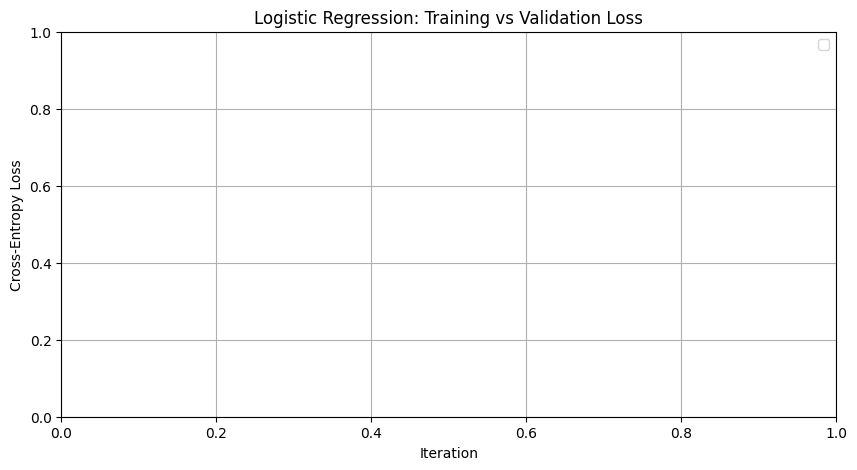

In [18]:
# TODO: Plot training and validation loss curves (1 points)

plt.figure(figsize=(10, 5))
# TODO: Create the plot  (1 points)
if plot_train_losses is not None and plot_val_losses is not None:
    plt.plot(plot_train_losses, label='Training Loss')
    plt.plot(plot_val_losses, label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('Cross-Entropy Loss')
plt.title('Logistic Regression: Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

**Question 2:** Why do we use the sigmoid function in Logistic Regression? (4 points, 4-5 sentences)

**The sigmoid function is used in Logistic Regression to transform the linear combination of features into a probability value between 0 and 1. This transformation allows the model to output probabilities that can be interpreted as the likelihood of belonging to the positive class. The sigmoid function's S-shaped curve ensures that small changes in the input near the decision boundary result in significant changes in probability, while large positive or negative inputs are mapped to probabilities close to 1 or 0 respectively. This probabilistic output enables threshold-based classification and provides meaningful confidence scores for predictions.**

---

# Task 3: Decision Tree (30 points)

Implement a Decision Tree classifier using information gain (entropy) for multi-class classification of all three Iris species.

**Hyperparameters to tune:**
- Maximum depth: `[3, 5, 10]`
- Minimum samples to split: `[2, 5, 10]`

## 3.1: Implement DecisionTree Class (20 points)

In [20]:
class DecisionTreeNode:
    """A node in the decision tree."""
    
    def __init__(self, feature_idx=None, threshold=None, left=None, right=None, value=None):
        """
        Initialise a tree node.
        
        For internal nodes:
            feature_idx: Index of feature to split on
            threshold: Threshold value for the split
            left: Left child node (feature <= threshold)
            right: Right child node (feature > threshold)
        
        For leaf nodes:
            value: Predicted class label
        """
        self.feature_idx = feature_idx
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
    
    def is_leaf(self):
        """Check if this node is a leaf."""
        return self.value is not None


class DecisionTree:
    """
    Decision Tree classifier using information gain (entropy).
    
    Attributes:
        max_depth: Maximum depth of the tree
        min_samples_split: Minimum samples required to split a node
        min_samples_leaf: Minimum samples required in a leaf node
        root: Root node of the tree
    """
    
    def __init__(self, max_depth=10, min_samples_split=2, min_samples_leaf=1):
        """
        Initialise the Decision Tree.
        
        Args:
            max_depth: Maximum depth of the tree
            min_samples_split: Minimum samples required to split
            min_samples_leaf: Minimum samples required in a leaf (fixed 1)
        """
        # TODO: Store hyperparameters (1 points)
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.root = None
    
    def _entropy(self, y):
        """
        Compute entropy of a label array.
        
        Entropy = -sum(p * log2(p)) for each class
        
        Hint: Handle the case where p=0 (0 * log(0) = 0)
        """
        # TODO: Implement entropy calculation (2 points)
        if len(y) == 0:
            return 0
        
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        entropy = 0
        for p in probabilities:
            if p > 0:
                entropy -= p * np.log2(p)
        return entropy
    
    def _information_gain(self, y, y_left, y_right):
        """
        Compute information gain from a split.
        
        IG = entropy(parent) - weighted_avg(entropy(children))
        """
        # TODO: Implement information gain (2 points)
        parent_entropy = self._entropy(y)
        n = len(y)
        n_left, n_right = len(y_left), len(y_right)
        
        if n_left == 0 or n_right == 0:
            return 0
        
        weighted_entropy = (n_left / n) * self._entropy(y_left) + (n_right / n) * self._entropy(y_right)
        return parent_entropy - weighted_entropy
    
    def _best_split(self, X, y):
        """
        Find the best feature and threshold to split on.
        
        Returns:
            best_feature_idx, best_threshold, best_gain
            Returns (None, None, 0) if no valid split found
        """
        # TODO: Implement best split search (5 points)
        # Steps:
        # 1. For each feature:
        #    a. Get unique values as potential thresholds
        #    b. For each threshold:
        #       - Split data into left (<=) and right (>)
        #       - Check min_samples_leaf constraint
        #       - Compute information gain
        #       - Track best split
        # 2. Return best feature, threshold, and gain
        best_gain = 0
        best_feature_idx = None
        best_threshold = None
        
        n_samples, n_features = X.shape
        
        for feature_idx in range(n_features):
            feature_values = X[:, feature_idx]
            unique_values = np.unique(feature_values)
            
            for threshold in unique_values:
                left_mask = feature_values <= threshold
                right_mask = feature_values > threshold
                
                y_left, y_right = y[left_mask], y[right_mask]
                
                if len(y_left) < self.min_samples_leaf or len(y_right) < self.min_samples_leaf:
                    continue
                
                gain = self._information_gain(y, y_left, y_right)
                
                if gain > best_gain:
                    best_gain = gain
                    best_feature_idx = feature_idx
                    best_threshold = threshold
        
        return best_feature_idx, best_threshold, best_gain
    
    def _build_tree(self, X, y, depth=0):
        """
        Recursively build the decision tree.
        
        Args:
            X: Features
            y: Labels
            depth: Current depth
        
        Returns:
            DecisionTreeNode
        """
        # TODO: Implement recursive tree building (6 points)
        # Steps:
        # 1. Check stopping conditions:
        #    - max_depth reached
        #    - all samples same class
        #    - n_samples < min_samples_split
        #    If stopping, return leaf with majority class
        #
        # 2. Find best split
        #    If no valid split, return leaf
        #
        # 3. Split data and recursively build children
        #
        # 4. Return internal node with split info
        n_samples = len(y)
        
        # Check stopping conditions
        if (depth >= self.max_depth or 
            len(np.unique(y)) == 1 or 
            n_samples < self.min_samples_split):
            # Return leaf with majority class
            majority_class = np.bincount(y).argmax()
            return DecisionTreeNode(value=majority_class)
        
        # Find best split
        best_feature_idx, best_threshold, best_gain = self._best_split(X, y)
        
        if best_gain == 0:
            # No valid split found
            majority_class = np.bincount(y).argmax()
            return DecisionTreeNode(value=majority_class)
        
        # Split data
        left_mask = X[:, best_feature_idx] <= best_threshold
        right_mask = X[:, best_feature_idx] > best_threshold
        
        X_left, y_left = X[left_mask], y[left_mask]
        X_right, y_right = X[right_mask], y[right_mask]
        
        # Recursively build children
        left_child = self._build_tree(X_left, y_left, depth + 1)
        right_child = self._build_tree(X_right, y_right, depth + 1)
        
        # Return internal node
        return DecisionTreeNode(
            feature_idx=best_feature_idx,
            threshold=best_threshold,
            left=left_child,
            right=right_child
        )
    
    def fit(self, X, y):
        """
        Train the decision tree.
        
        Args:
            X: Training features
            y: Training labels
        
        Returns:
            self
        """
        # TODO: Build the tree (2 points)
        self.root = self._build_tree(X, y)
        return self
    
    def _predict_sample(self, x, node):
        """
        Predict class for a single sample by traversing the tree.
        """
        # TODO: Traverse tree to make prediction (1 points)
        if node.is_leaf():
            return node.value
        
        if x[node.feature_idx] <= node.threshold:
            return self._predict_sample(x, node.left)
        else:
            return self._predict_sample(x, node.right)
    
    def predict(self, X):
        """
        Make predictions for all samples.
        
        Args:
            X: Features
        
        Returns:
            Array of predictions
        """
        # TODO: Predict for each sample (1 points)
        return np.array([self._predict_sample(x, self.root) for x in X])

## 3.2: 5-Fold Cross-Validation for Decision Tree (10 points)

**Steps:**
1. Prepare data: Multi-class classification (all 3 classes)
2. For each fold:
   - Split train into train_inner and validation (80%-20%)
   - Grid search over hyperparameters using validation set
   - Train final model with best hyperparameters on full train set
   - Evaluate on test set
3. Report results with mean, std, and 95% CI
4. Plot validation accuracy for different max_depth values

In [21]:
# Prepare data for Decision Tree
# Multi-class classification: all 3 classes
X_tree = X_full.copy()
y_tree = y_full.copy()

print(f"Decision Tree Data:")
print(f"  X shape: {X_tree.shape}")
print(f"  y shape: {y_tree.shape}")
print(f"  Classes: {list(iris.target_names)}")

# Hyperparameter grid
max_depths = [3, 5, 10]
min_samples_leafs = [1, 2, 4]

# Storage for results
accuracy_scores = []
precision_scores_list = []
recall_scores_list = []
f1_scores_list = []
best_params_per_fold = []

# For plotting (track validation accuracy vs max_depth from one fold)
depth_val_accuracies = {d: [] for d in max_depths}

# 5-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=seed)

print("\n" + "="*60)
print("DECISION TREE: 5-FOLD CROSS-VALIDATION")
print("="*60)

for fold_num, (train_idx, test_idx) in enumerate(kf.split(X_tree), 1):
    print(f"\n--- Fold {fold_num} ---")
    
    # Split data
    X_train_full, X_test = X_tree[train_idx], X_tree[test_idx]
    y_train_full, y_test = y_tree[train_idx], y_tree[test_idx]
    
    # TODO: Further split train into train_inner and validation (80%-20%)
    split_idx = max(1, int(0.8 * len(X_train_full)))  # Ensure at least 1 sample for training
    X_train_inner, X_val = X_train_full[:split_idx], X_train_full[split_idx:]
    y_train_inner, y_val = y_train_full[:split_idx], y_train_full[split_idx:]
    
    # Ensure validation set is not empty
    if len(X_val) == 0:
        # If validation set is empty, use last sample from training as validation
        split_idx = len(X_train_full) - 1
        X_train_inner, X_val = X_train_full[:split_idx], X_train_full[split_idx:]
        y_train_inner, y_val = y_train_full[:split_idx], y_train_full[split_idx:]
    
    # TODO: Grid search over hyperparameters (5 points)
    # For each combination of (max_depth, min_samples_split, min_samples_leaf):
    #   1. Train model on train_inner
    #   2. Evaluate on validation set
    #   3. Track best parameters
    #   4. For plotting: track average val accuracy for each max_depth
    best_val_acc = 0
    best_params = None
    
    for max_depth in max_depths:
        fold_depth_acc = []
        for min_samples_split in [2, 5, 10]:
            for min_samples_leaf in min_samples_leafs:
                model = DecisionTree(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
                model.fit(X_train_inner, y_train_inner)
                val_pred = model.predict(X_val)
                val_acc = accuracy_score(y_val, val_pred)
                fold_depth_acc.append(val_acc)
                
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    best_params = (max_depth, min_samples_split, min_samples_leaf)
        
        # Track average accuracy for this max_depth
        depth_val_accuracies[max_depth].append(np.mean(fold_depth_acc))
    
    best_params_per_fold.append(best_params)
    # TODO: Train final model with best parameters on full training set (1 points)
    final_model = DecisionTree(max_depth=best_params[0], min_samples_split=best_params[1], min_samples_leaf=best_params[2])
    final_model.fit(X_train_full, y_train_full)
    
    # TODO: Evaluate on test set and store results (1 points)
    # Store: accuracy, precision (macro), recall (macro), f1 (macro)
    y_pred = final_model.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores_list.append(precision_score(y_test, y_pred, average='macro'))
    recall_scores_list.append(recall_score(y_test, y_pred, average='macro'))
    f1_scores_list.append(f1_score(y_test, y_pred, average='macro'))
    
    print(f"Best params: max_depth={best_params[0]}, min_split={best_params[1]}, min_leaf={best_params[2]}")
    print(f"Test Acc: {accuracy_scores[-1]:.4f}, Prec: {precision_scores_list[-1]:.4f}, Rec: {recall_scores_list[-1]:.4f}, F1: {f1_scores_list[-1]:.4f}")

# TODO: Print final results with mean, std, and 95% CI for all metrics (1 points)
print("\n" + "="*60)
print("DECISION TREE: FINAL RESULTS")
print("="*60)

print_results("Accuracy", accuracy_scores)
print_results("Precision (Macro)", precision_scores_list)
print_results("Recall (Macro)", recall_scores_list)
print_results("F1 Score (Macro)", f1_scores_list)

Decision Tree Data:
  X shape: (150, 4)
  y shape: (150,)
  Classes: [np.str_('setosa'), np.str_('versicolor'), np.str_('virginica')]

DECISION TREE: 5-FOLD CROSS-VALIDATION

--- Fold 1 ---
Best params: max_depth=5, min_split=2, min_leaf=1
Test Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000

--- Fold 2 ---
Best params: max_depth=3, min_split=2, min_leaf=4
Test Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000

--- Fold 3 ---
Best params: max_depth=3, min_split=2, min_leaf=1
Test Acc: 0.9333, Prec: 0.9333, Rec: 0.9333, F1: 0.9259

--- Fold 4 ---
Best params: max_depth=5, min_split=2, min_leaf=1
Test Acc: 0.9333, Prec: 0.9389, Rec: 0.9389, F1: 0.9389

--- Fold 5 ---
Best params: max_depth=3, min_split=2, min_leaf=4
Test Acc: 0.9667, Prec: 0.9722, Rec: 0.9722, F1: 0.9710

DECISION TREE: FINAL RESULTS
Accuracy: 0.9667 ± 0.0333 (95% CI: [0.9253, 1.0080])
Precision (Macro): 0.9689 ± 0.0321 (95% CI: [0.9291, 1.0087])
Recall (Macro): 0.9689 ± 0.0321 (95% CI: [0.9291, 1.0087])
F1 Score (Ma

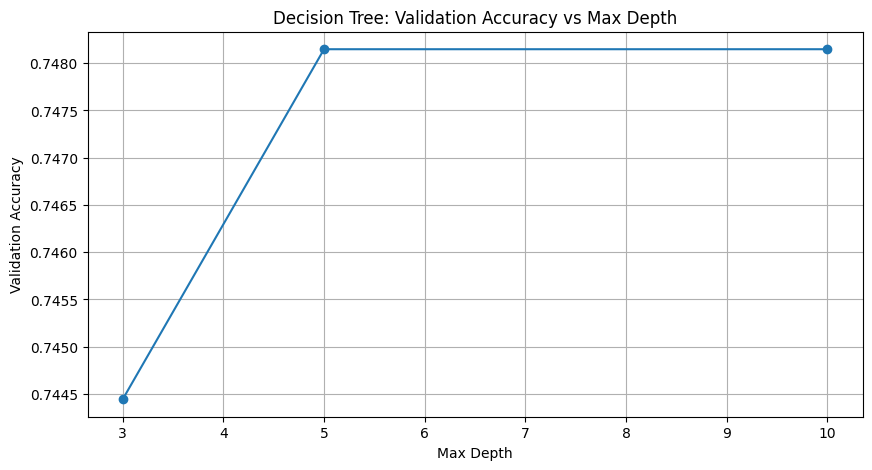

In [22]:
# TODO: Plot validation accuracy vs max_depth (1 points)

plt.figure(figsize=(10, 5))
# TODO: Create the plot (1 points)
plt.plot(max_depths, [np.mean(depth_val_accuracies[d]) for d in max_depths], marker='o')
plt.xlabel('Max Depth')
plt.ylabel('Validation Accuracy')
plt.title('Decision Tree: Validation Accuracy vs Max Depth')
plt.grid(True)
plt.show()

**Question 3:** What are the risks of having a tree that is too shallow or too deep? (4 points, 4-5 sentences)

**A tree that is too shallow (low maximum depth) risks underfitting the training data, resulting in poor performance on both training and test sets. This occurs because the model cannot capture complex patterns in the data, leading to high bias. Conversely, a tree that is too deep risks overfitting, where the model memorizes noise and specific training examples rather than learning general patterns. This results in excellent performance on training data but poor generalization to unseen test data, manifesting as high variance. The optimal tree depth balances these trade-offs, achieving good generalization performance.**

---

# Convert Your Colab Notebook to PDF

### Step 1: Download Your Notebook
- Go to **File → Download → Download .ipynb**
- Save the file to your computer

### Step 2: Upload to Colab
- Click the **📁 folder icon** on the left sidebar
- Click the **upload button**
- Select your downloaded .ipynb file
- Wait for the upload to complete

### Step 3: Run the Code Below
- **Uncomment the cell below** and run the cell
- This will take about 1-2 minutes to install required packages

### Step 4: Enter Notebook Name
- When prompted, type your notebook name (e.g., `gs_000000_project.ipynb`)
- Press Enter

### The PDF will automatically download to your computer

In [48]:
# # Install required packages (this takes about 30 seconds)
# print("Installing PDF converter... please wait...")
# !apt-get update -qq
# !apt-get install -y texlive-xetex texlive-fonts-recommended texlive-plain-generic pandoc > /dev/null 2>&1
# !pip install -q nbconvert

# print("\n" + "="*50)
# print("COLAB NOTEBOOK TO PDF CONVERTER")
# print("="*50)
# print("\nSTEP 1: Download your notebook")
# print("- Go to File → Download → Download .ipynb")
# print("- Save it to your computer")
# print("\nSTEP 2: Upload it here")
# print("- Click the folder icon on the left (📁)")
# print("- Click the upload button and select your .ipynb file")
# print("- Wait for upload to complete")
# print("\nSTEP 3: Enter the filename below")
# print("="*50)

# # Get notebook name from user
# notebook_name = input("\nEnter your notebook name: ")

# # Add .ipynb if missing
# if not notebook_name.endswith('.ipynb'):
#     notebook_name += '.ipynb'

# import os
# notebook_path = f'/content/{notebook_name}'

# # Check if file exists
# if not os.path.exists(notebook_path):
#     print(f"\n⚠ Error: '{notebook_name}' not found in /content/")
#     print("\nMake sure you uploaded the file using the folder icon (📁) on the left!")
# else:
#     print(f"\n✔ Found {notebook_name}")
#     print("Converting to PDF... this may take 1-2 minutes...\n")

#     # Convert the notebook to PDF
#     !jupyter nbconvert --to pdf "{notebook_path}"

#     # Download the PDF
#     from google.colab import files
#     pdf_name = notebook_name.replace('.ipynb', '.pdf')
#     pdf_path = f'/content/{pdf_name}'

#     if os.path.exists(pdf_path):
#         print("✔ SUCCESS! Downloading your PDF now...")
#         files.download(pdf_path)
#         print("\n✔ Done! Check your downloads folder.")
#     else:
#         print("⚠ Error: Could not create PDF")